In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv(r"NSE-Tata-Global-Beverages-Limited\NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


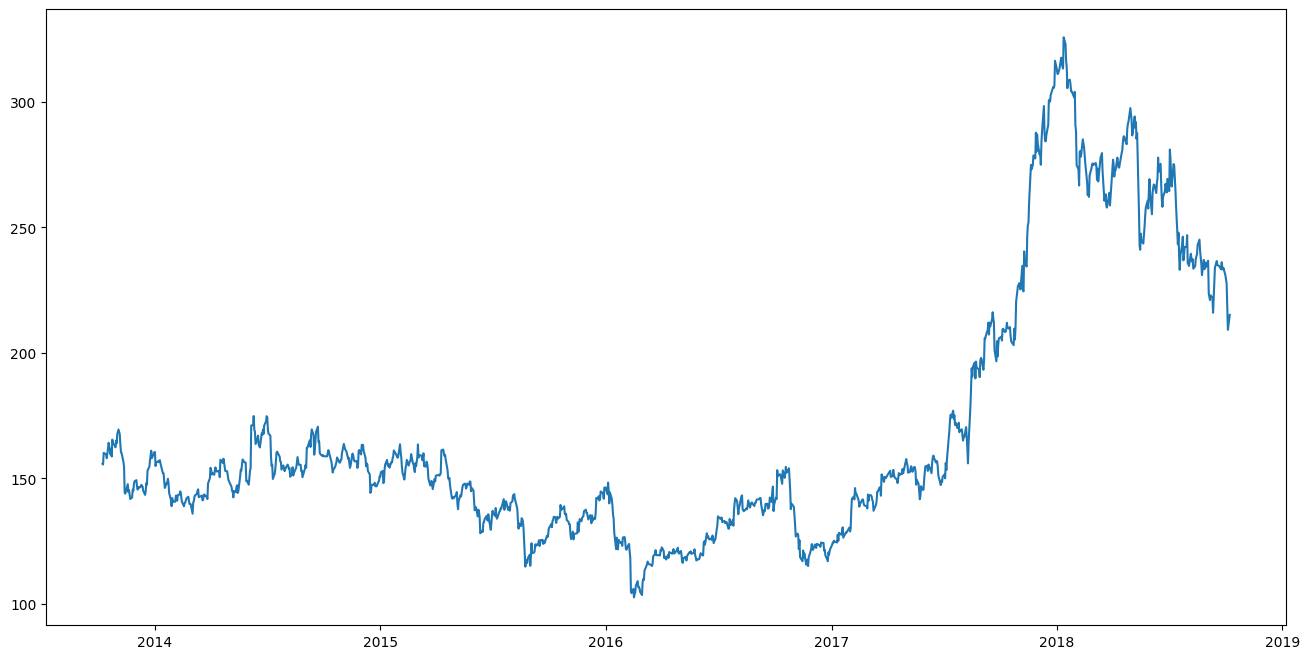

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [4]:
# Sort the original data
data = df.sort_index(ascending=True, axis=0)

# Initialize a new DataFrame
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

# Populate new_dataset with 'Date' and 'Close' columns
for i in range(0, len(data)):
    new_dataset.iloc[i, 0] = data.iloc[i]['Date']
    new_dataset.iloc[i, 1] = data.iloc[i]['Close']

In [5]:
# Convert 'Date' to datetime format if necessary
new_dataset['Date'] = pd.to_datetime(new_dataset['Date'])

# Set 'Date' as the index
new_dataset.set_index('Date', inplace=True)

# Continue with the rest of the code
scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset = new_dataset.values

# Define training and testing data
train_data = final_dataset[0:987, :]
test_data = final_dataset[987:, :] 

# Scale the data
scaled_data = scaler.fit_transform(final_dataset)

# Prepare training data
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape x_train_data
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Prepare testing data
x_test_data, y_test_data = [], []
for i in range(60, len(test_data)):
    x_test_data.append(scaled_data[len(train_data) + i - 60:len(train_data) + i, 0])
    y_test_data.append(scaled_data[len(train_data) + i, 0])

x_test_data, y_test_data = np.array(x_test_data), np.array(y_test_data)

# Reshape x_test_data
x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))

In [7]:
# Define the LSTM model with more layers and Dropout
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with the Adam optimizer
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with increased epochs and early stopping
history = lstm_model.fit(
    x_train_data, y_train_data, 
    epochs=100, batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    verbose=2
)

# Prepare test data (assuming 'scaler' and 'valid_data' are defined)
inputs_data = new_dataset[len(new_dataset) - len(test_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)
# lstm_model.compile(loss='mean_squared_error',optimizer='adam')

Epoch 1/100
24/24 - 9s - 378ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 2/100
24/24 - 2s - 73ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3/100
24/24 - 3s - 118ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 4/100
24/24 - 2s - 78ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 5/100
24/24 - 2s - 81ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 6/100
24/24 - 1s - 57ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
24/24 - 2s - 86ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/100
24/24 - 2s - 104ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/100
24/24 - 2s - 75ms/step - loss: 9.3167e-04 - val_loss: 0.0021
Epoch 10/100
24/24 - 2s - 102ms/step - loss: 8.6061e-04 - val_loss: 0.0011
Epoch 11/100
24/24 - 2s - 94ms/step - loss: 8.7407e-04 - val_loss: 0.0015
Epoch 12/100
24/24 - 2s - 75ms/step - loss: 8.2099e-04 - val_loss: 0.0012
Epoch 13/100
24/24 - 2s - 77ms/step - loss: 8.2353e-04 - val_loss: 0.0023
Epoch 14/100
24/24 - 2s - 74ms/step - loss: 9.8921e-04 - val_loss: 0.0024
E

In [13]:
# Create the test dataset
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create y_test_data
y_test_data = []
for i in range(60, inputs_data.shape[0]):
    y_test_data.append(inputs_data[i, 0])  # The next value after the sequence
y_test_data = np.array(y_test_data)

# Make predictions on the test set
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

# Evaluate on the test set (assuming y_test_data is defined)
mae = mean_absolute_error(y_test_data, predicted_closing_price)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mean Absolute Error: 254.98477560755325


In [14]:
lstm_model.save("stock_tata.h5")

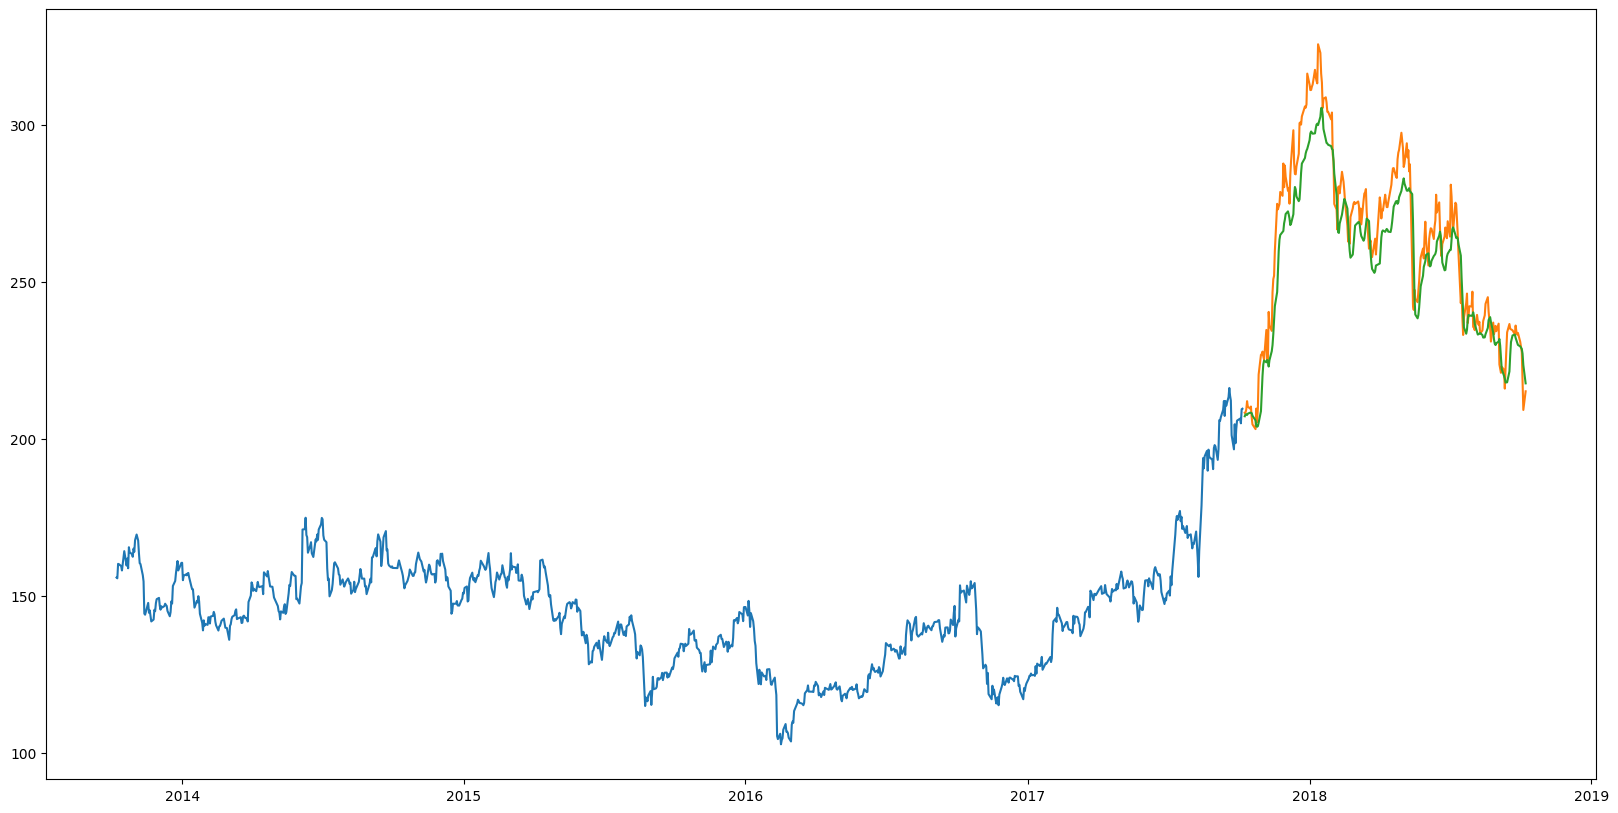

In [15]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])